Using device: cuda

Running experiment with 1 computation neurons per selection neuron

Epoch 1: Train Loss: 0.8221, Test Loss: 0.3437, Test Accuracy: 90.23%
Layer 1 Entropy: 0.0000, Layer 2 Entropy: 0.0000
Layer 1 Selection Ratios: [1.]
Layer 2 Selection Ratios: [1.]

Epoch 2: Train Loss: 0.3148, Test Loss: 0.2740, Test Accuracy: 92.04%
Layer 1 Entropy: 0.0000, Layer 2 Entropy: 0.0000
Layer 1 Selection Ratios: [1.]
Layer 2 Selection Ratios: [1.]

Epoch 3: Train Loss: 0.2618, Test Loss: 0.2337, Test Accuracy: 93.26%
Layer 1 Entropy: 0.0000, Layer 2 Entropy: 0.0000
Layer 1 Selection Ratios: [1.]
Layer 2 Selection Ratios: [1.]

Epoch 4: Train Loss: 0.2266, Test Loss: 0.2067, Test Accuracy: 94.05%
Layer 1 Entropy: 0.0000, Layer 2 Entropy: 0.0000
Layer 1 Selection Ratios: [1.]
Layer 2 Selection Ratios: [1.]

Epoch 5: Train Loss: 0.2005, Test Loss: 0.1858, Test Accuracy: 94.67%
Layer 1 Entropy: 0.0000, Layer 2 Entropy: 0.0000
Layer 1 Selection Ratios: [1.]
Layer 2 Selection Ratios: [1.]


R

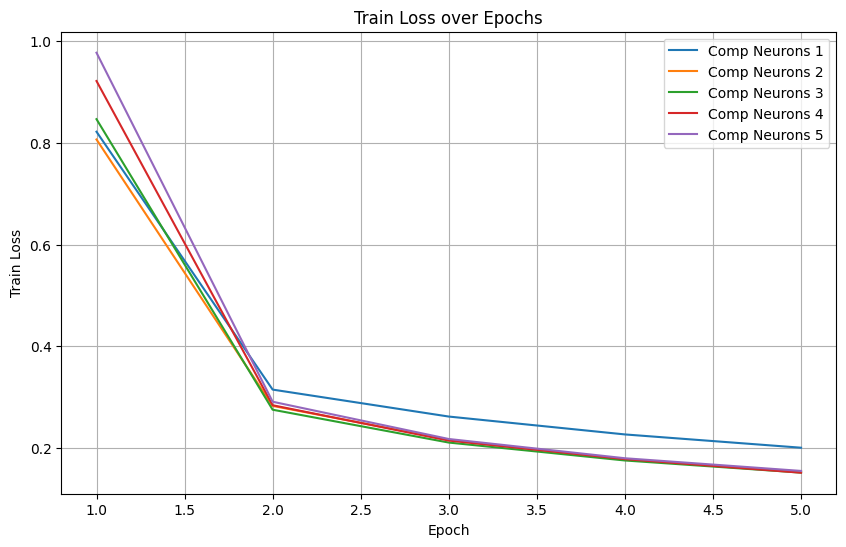

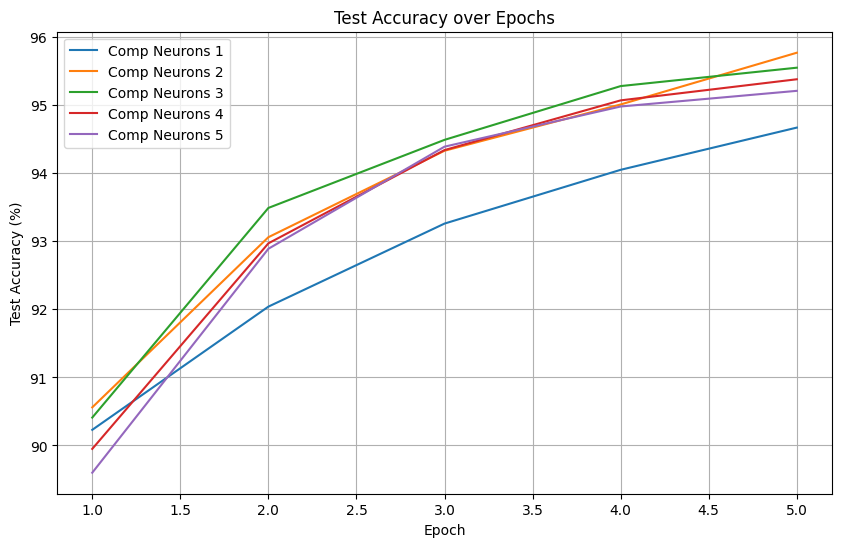

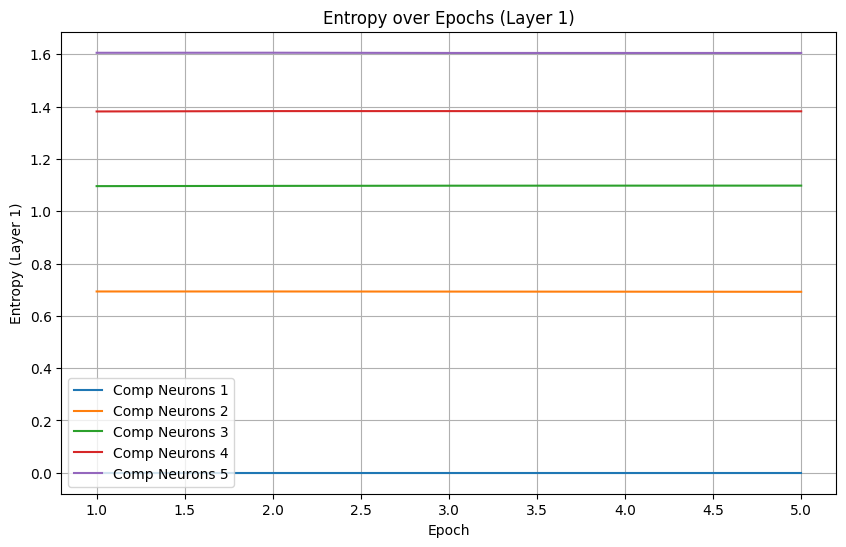

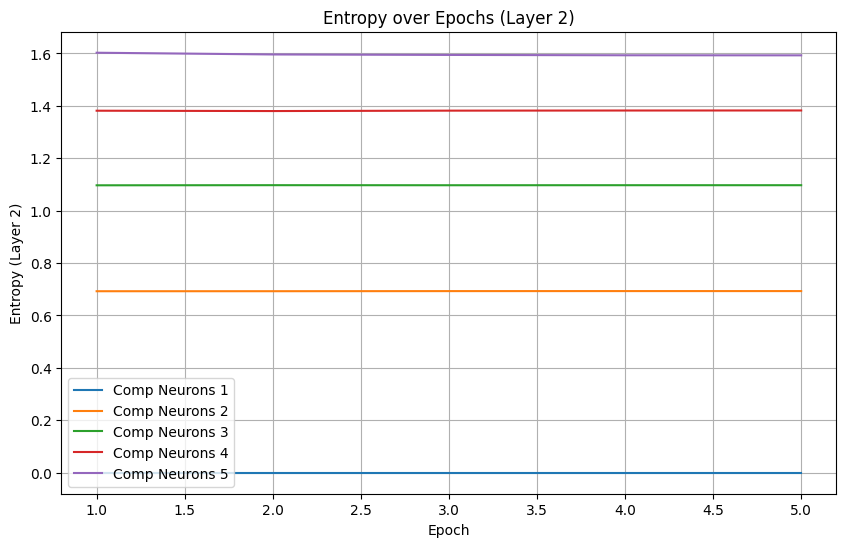

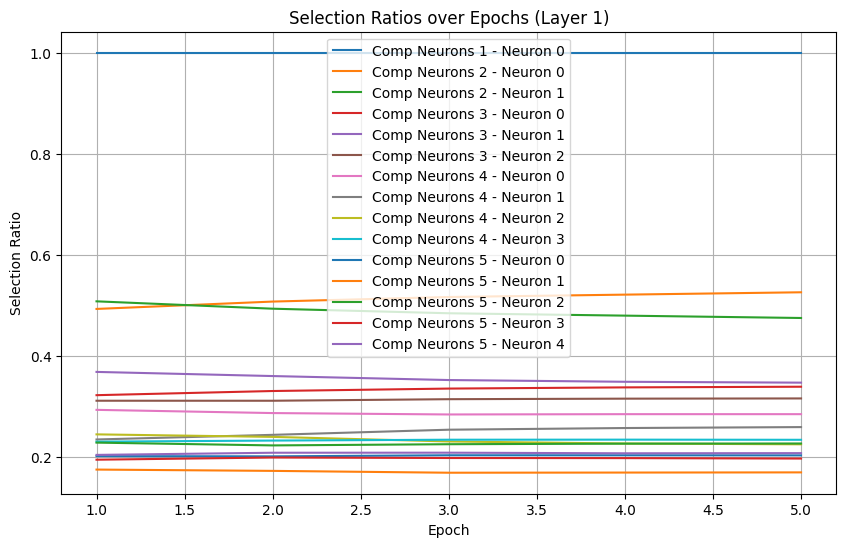

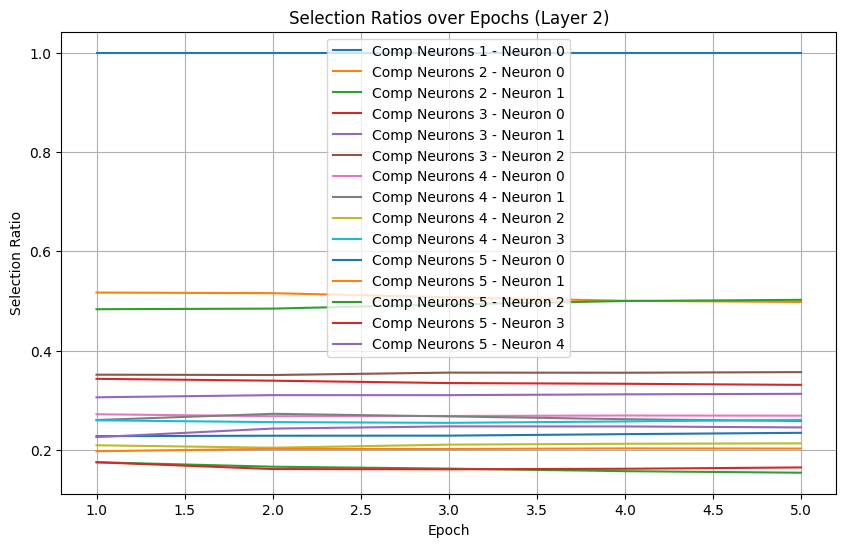

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Function to compute entropy
def compute_entropy(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return -np.sum(p * np.log(p), axis=-1)

# Prepare the MNIST dataset and load it into GPU memory
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the entire training dataset
train_dataset_full = datasets.MNIST(root='./data', train=True,
                                    transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                              transform=transform)

# Move training data to GPU
train_data = train_dataset_full.data.float().div(255).unsqueeze(1).to(device)  # Shape: [60000, 1, 28, 28]
train_data = train_data.sub_(0.1307).div_(0.3081)  # Normalize
train_targets = train_dataset_full.targets.to(device)  # Shape: [60000]

# Similarly for test data
test_data = test_dataset.data.float().div(255).unsqueeze(1).to(device)  # Shape: [10000, 1, 28, 28]
test_data = test_data.sub_(0.1307).div_(0.3081)  # Normalize
test_targets = test_dataset.targets.to(device)  # Shape: [10000]

# Function to create DataLoader from in-memory data
def create_data_loader(data, targets, batch_size):
    dataset = torch.utils.data.TensorDataset(data, targets)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

# Define the custom neuron module with variable computation neurons
class CustomNeuron(nn.Module):
    def __init__(self, input_size, num_comp_neurons):
        super(CustomNeuron, self).__init__()
        self.num_comp_neurons = num_comp_neurons
        # Selection neuron outputs N logits
        self.selection_layer = nn.Linear(input_size, num_comp_neurons)
        # Computation neurons (linear layers)
        self.comp_layers = nn.ModuleList([nn.Linear(input_size, 1) for _ in range(num_comp_neurons)])
    
    def forward(self, x):
        # Selection logits
        selection_logits = self.selection_layer(x)  # Shape: [batch_size, num_comp_neurons]
        # Softmax to get selection probabilities
        selection_probs = F.softmax(selection_logits, dim=1)  # Shape: [batch_size, num_comp_neurons]
        
        # Hard selection using argmax
        with torch.no_grad():
            selected_idx = torch.argmax(selection_probs, dim=1)  # Shape: [batch_size]
            selected_mask_hard = F.one_hot(selected_idx, num_classes=self.num_comp_neurons).float()  # Shape: [batch_size, num_comp_neurons]
        # Straight-through estimator
        selected_mask = selected_mask_hard - selection_probs.detach() + selection_probs  # Shape: [batch_size, num_comp_neurons]
        
        # Compute outputs from all computation neurons
        comp_outputs = [torch.relu(comp_layer(x)) for comp_layer in self.comp_layers]  # List of [batch_size, 1]
        comp_outputs = torch.cat(comp_outputs, dim=1)  # Shape: [batch_size, num_comp_neurons]
        
        # Combine outputs using selected_mask
        comp_output = torch.sum(comp_outputs * selected_mask, dim=1, keepdim=True)  # Shape: [batch_size, 1]
        
        # Store selected_mask_hard for analysis
        self.selected_mask_hard = selected_mask_hard.detach()
        
        return comp_output

# Define the custom layer module
class CustomLayer(nn.Module):
    def __init__(self, input_size, output_size, num_comp_neurons):
        super(CustomLayer, self).__init__()
        self.neurons = nn.ModuleList([CustomNeuron(input_size, num_comp_neurons) for _ in range(output_size)])
    
    def forward(self, x):
        outputs = []
        selected_masks_hard = []
        for neuron in self.neurons:
            output = neuron(x)  # Each output is [batch_size, 1]
            outputs.append(output)
            selected_masks_hard.append(neuron.selected_mask_hard)  # Each is [batch_size, num_comp_neurons]
        x_out = torch.cat(outputs, dim=1)  # Shape: [batch_size, output_size]
        selected_masks_hard = torch.stack(selected_masks_hard, dim=1)  # Shape: [batch_size, output_size, num_comp_neurons]
        self.selected_masks_hard = selected_masks_hard  # For analysis
        return x_out

# Define the custom network
class CustomNet(nn.Module):
    def __init__(self, num_comp_neurons):
        super(CustomNet, self).__init__()
        self.layer1 = CustomLayer(28*28, 64, num_comp_neurons)  # Input layer
        self.layer2 = CustomLayer(64, 64, num_comp_neurons)     # Hidden layer
        self.fc = nn.Linear(64, 10)           # Output layer
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        
        # Pass through the first custom layer
        x = self.layer1(x)
        selected_masks_layer1 = self.layer1.selected_masks_hard  # Shape: [batch_size, 64, num_comp_neurons]
        
        # Pass through the second custom layer
        x = self.layer2(x)
        selected_masks_layer2 = self.layer2.selected_masks_hard  # Shape: [batch_size, 64, num_comp_neurons]
        
        # Output layer
        x = self.fc(x)
        
        # Store selected masks for analysis
        self.selected_masks_layer1 = selected_masks_layer1
        self.selected_masks_layer2 = selected_masks_layer2
        
        return x

# Number of computation neurons to test
comp_neurons_list = [1, 2, 3, 4, 5]
num_epochs = 5

# Dictionaries to store metrics for each run
all_train_losses = {}
all_test_losses = {}
all_test_accuracies = {}
all_entropy_layer1 = {}
all_entropy_layer2 = {}
all_selection_ratios_layer1 = {}
all_selection_ratios_layer2 = {}

for num_comp_neurons in comp_neurons_list:
    print(f'\nRunning experiment with {num_comp_neurons} computation neurons per selection neuron\n')
    # Initialize the network, criterion, and optimizer
    model = CustomNet(num_comp_neurons).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    # Create DataLoaders
    batch_size = 64
    train_loader = create_data_loader(train_data, train_targets, batch_size)
    test_loader = create_data_loader(test_data, test_targets, 1000)
    
    # Initialize lists to store metrics
    epoch_train_losses = []
    epoch_test_losses = []
    epoch_test_accuracies = []
    epoch_entropy_layer1 = []
    epoch_entropy_layer2 = []
    epoch_selection_ratios_layer1 = []
    epoch_selection_ratios_layer2 = []
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        # Initialize selection counts for entropy calculation
        selection_counts_layer1 = torch.zeros(model.layer1.neurons.__len__(), num_comp_neurons).to(device)  # Shape: [64, num_comp_neurons]
        selection_counts_layer2 = torch.zeros(model.layer2.neurons.__len__(), num_comp_neurons).to(device)  # Shape: [64, num_comp_neurons]
        total_selections_layer1 = 0
        total_selections_layer2 = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Data is already on device
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            
            optimizer.step()
            
            # Accumulate training loss
            train_loss += loss.item() * data.size(0)
            
            # Collect selection counts
            selected_masks_layer1 = model.selected_masks_layer1  # Shape: [batch_size, 64, num_comp_neurons]
            selected_masks_layer2 = model.selected_masks_layer2  # Shape: [batch_size, 64, num_comp_neurons]
            
            # Sum over batch dimension
            selection_counts_layer1 += selected_masks_layer1.sum(dim=0)  # Shape: [64, num_comp_neurons]
            total_selections_layer1 += selected_masks_layer1.shape[0]  # Number of samples in batch
            
            selection_counts_layer2 += selected_masks_layer2.sum(dim=0)  # Shape: [64, num_comp_neurons]
            total_selections_layer2 += selected_masks_layer2.shape[0]  # Number of samples in batch
        
        # Compute average loss for the epoch
        train_loss /= len(train_loader.dataset)
        epoch_train_losses.append(train_loss)
        
        # Compute selection ratios
        selection_ratios_layer1 = selection_counts_layer1.sum(dim=0).cpu().numpy() / (total_selections_layer1 * model.layer1.neurons.__len__())
        selection_ratios_layer2 = selection_counts_layer2.sum(dim=0).cpu().numpy() / (total_selections_layer2 * model.layer2.neurons.__len__())
        epoch_selection_ratios_layer1.append(selection_ratios_layer1)
        epoch_selection_ratios_layer2.append(selection_ratios_layer2)
        
        # Compute entropy
        entropy_layer1 = compute_entropy(selection_ratios_layer1)
        entropy_layer2 = compute_entropy(selection_ratios_layer2)
        epoch_entropy_layer1.append(entropy_layer1)
        epoch_entropy_layer2.append(entropy_layer2)
        
        # Testing loop
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item() * data.size(0)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        epoch_test_losses.append(test_loss)
        epoch_test_accuracies.append(accuracy)
        
        # Print end-of-epoch results
        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
        print(f'Layer 1 Entropy: {np.sum(entropy_layer1):.4f}, Layer 2 Entropy: {np.sum(entropy_layer2):.4f}')
        print(f'Layer 1 Selection Ratios: {selection_ratios_layer1}')
        print(f'Layer 2 Selection Ratios: {selection_ratios_layer2}\n')
    
    # Store metrics for this run
    all_train_losses[num_comp_neurons] = epoch_train_losses
    all_test_losses[num_comp_neurons] = epoch_test_losses
    all_test_accuracies[num_comp_neurons] = epoch_test_accuracies
    all_entropy_layer1[num_comp_neurons] = epoch_entropy_layer1
    all_entropy_layer2[num_comp_neurons] = epoch_entropy_layer2
    all_selection_ratios_layer1[num_comp_neurons] = epoch_selection_ratios_layer1
    all_selection_ratios_layer2[num_comp_neurons] = epoch_selection_ratios_layer2

# Plotting results
epochs = range(1, num_epochs + 1)

# Plot loss over epochs
plt.figure(figsize=(10,6))
for num_comp_neurons in comp_neurons_list:
    plt.plot(epochs, all_train_losses[num_comp_neurons], label=f'Comp Neurons {num_comp_neurons}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy over epochs
plt.figure(figsize=(10,6))
for num_comp_neurons in comp_neurons_list:
    plt.plot(epochs, all_test_accuracies[num_comp_neurons], label=f'Comp Neurons {num_comp_neurons}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot entropy over epochs for Layer 1
plt.figure(figsize=(10,6))
for num_comp_neurons in comp_neurons_list:
    entropy_values = [np.sum(e) for e in all_entropy_layer1[num_comp_neurons]]
    plt.plot(epochs, entropy_values, label=f'Comp Neurons {num_comp_neurons}')
plt.xlabel('Epoch')
plt.ylabel('Entropy (Layer 1)')
plt.title('Entropy over Epochs (Layer 1)')
plt.legend()
plt.grid(True)
plt.show()

# Plot entropy over epochs for Layer 2
plt.figure(figsize=(10,6))
for num_comp_neurons in comp_neurons_list:
    entropy_values = [np.sum(e) for e in all_entropy_layer2[num_comp_neurons]]
    plt.plot(epochs, entropy_values, label=f'Comp Neurons {num_comp_neurons}')
plt.xlabel('Epoch')
plt.ylabel('Entropy (Layer 2)')
plt.title('Entropy over Epochs (Layer 2)')
plt.legend()
plt.grid(True)
plt.show()

# Plot selection ratios over epochs for Layer 1
plt.figure(figsize=(10,6))
for num_comp_neurons in comp_neurons_list:
    selection_ratios = np.array(all_selection_ratios_layer1[num_comp_neurons])  # Shape: [num_epochs, num_comp_neurons]
    for i in range(num_comp_neurons):
        plt.plot(epochs, selection_ratios[:, i], label=f'Comp Neurons {num_comp_neurons} - Neuron {i}')
plt.xlabel('Epoch')
plt.ylabel('Selection Ratio')
plt.title('Selection Ratios over Epochs (Layer 1)')
plt.legend()
plt.grid(True)
plt.show()

# Plot selection ratios over epochs for Layer 2
plt.figure(figsize=(10,6))
for num_comp_neurons in comp_neurons_list:
    selection_ratios = np.array(all_selection_ratios_layer2[num_comp_neurons])  # Shape: [num_epochs, num_comp_neurons]
    for i in range(num_comp_neurons):
        plt.plot(epochs, selection_ratios[:, i], label=f'Comp Neurons {num_comp_neurons} - Neuron {i}')
plt.xlabel('Epoch')
plt.ylabel('Selection Ratio')
plt.title('Selection Ratios over Epochs (Layer 2)')
plt.legend()
plt.grid(True)
plt.show()


Number of computation neurons used in this analysis: 2


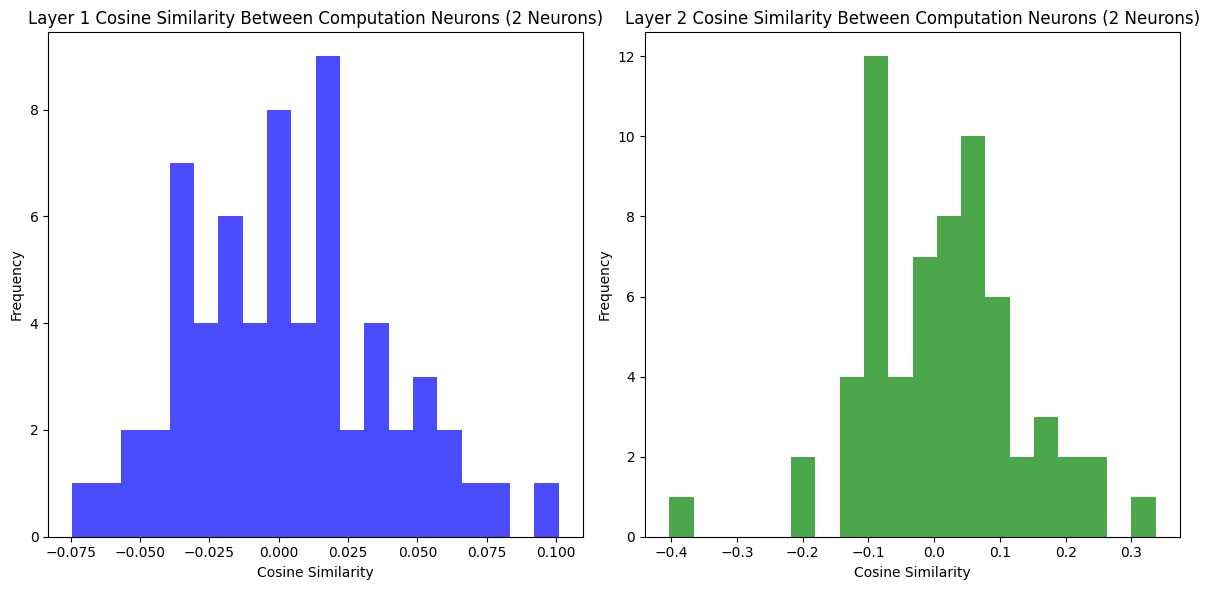

In [6]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Function to calculate pairwise cosine similarity between all computation neurons in a layer
def calculate_all_pairwise_cosine_similarity(layer):
    num_comp_neurons = layer.neurons[0].num_comp_neurons
    cosine_similarities = []
    
    for neuron in layer.neurons:
        # Get weights for all computation neurons in the current neuron
        weights = [comp_layer.weight.data.view(-1) for comp_layer in neuron.comp_layers]
        
        # Calculate cosine similarity for all pairs of computation neurons
        for i in range(num_comp_neurons):
            for j in range(i + 1, num_comp_neurons):
                cos_sim = F.cosine_similarity(weights[i], weights[j], dim=0).item()
                cosine_similarities.append(cos_sim)
    
    return cosine_similarities

# Confirm and print the number of computation neurons
num_comp_neurons = model.layer1.neurons[0].num_comp_neurons
print(f"Number of computation neurons used in this analysis: {num_comp_neurons}")

# Check if we have 5 computation neurons as expected
assert num_comp_neurons == 2, f"Expected 5 computation neurons, but got {num_comp_neurons}."

# Calculate cosine similarity for both layers in the final model
cosine_similarities_layer1 = calculate_all_pairwise_cosine_similarity(model.layer1)
cosine_similarities_layer2 = calculate_all_pairwise_cosine_similarity(model.layer2)

# Plot cosine similarity distributions for Layer 1 and Layer 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(cosine_similarities_layer1, bins=20, alpha=0.7, color='blue')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title(f'Layer 1 Cosine Similarity Between Computation Neurons ({num_comp_neurons} Neurons)')

plt.subplot(1, 2, 2)
plt.hist(cosine_similarities_layer2, bins=20, alpha=0.7, color='green')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title(f'Layer 2 Cosine Similarity Between Computation Neurons ({num_comp_neurons} Neurons)')

plt.tight_layout()
plt.show()
